# Cascadia Landslide Data Post-Processing
## ShakeMap Integration and Unique ID Addition

This notebook performs final post-processing on Cascadia landslide dataset:
- Adding USGS M9 scenario ShakeMap seismic intensity data and adding unique identifiers to create the final dataset for visualization and analysis.
- rainfall data from the rainfall notebook

## ShakeMap Integration

This notebook integrates USGS ShakeMap intensity data with Cascadia landslide location data. The ShakeMap data is available at https://earthquake.usgs.gov/scenarios/eventpage/cszm9ensemble_se/shakemap/intensity. 

The process involves several key steps:

### 1. Data Loading and Parsing
- Load ShakeMap XML data containing seismic intensity measurements
- Parse XML structure to extract grid fields and data values
- Convert raw XML data into structured pandas DataFrame

### 2. Data Processing
- Extract seismic parameters: MMI (Modified Mercalli Intensity), PGA (Peak Ground Acceleration), PGV (Peak Ground Velocity), and PSA03
- Create spatial interpolators using nearest neighbor interpolation
- Analyze PGA value distributions across different intensity ranges

### 3. Landslide Data Integration
- Calculate centroids for landslide geometries
- Interpolate seismic values at landslide locations using spatial interpolation

### 4. Visualization and Analysis
- Create choropleth maps showing PGA values at landslide locations
- Generate statistical summaries of seismic intensities at landslide sites
- Export final integrated dataset with both geometric and seismic attributes


In [1]:
import pandas as pd
import geopandas as gpd 
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pyproj import Transformer


In [2]:
xml_file = 'shaking/grid.xml'
namespace = {'shakemap': 'http://earthquake.usgs.gov/eqcenter/shakemap'}

# Parse the XML file
tree = ET.parse(xml_file)
root = tree.getroot()

In [3]:
# Get the column names from the <grid_field> tags
fields = root.findall('shakemap:grid_field', namespace)
column_names = [field.get('name') for field in fields]

In [4]:
print(column_names)

['LON', 'LAT', 'MMI', 'PGA', 'PGV', 'PSA03', 'PSA10', 'PSA30', 'SVEL']


In [5]:
# Get the grid data, which is a long string of numbers
grid_data_text = root.find('shakemap:grid_data', namespace).text.strip()

In [6]:
# Use Numpy to convert the string into a numerical array
data_array = np.fromstring(grid_data_text, dtype=float, sep=' ')

In [7]:
# Reshape the 1D array into a 2D table (rows x columns)
num_columns = len(column_names)
data_array_2d = data_array.reshape(-1, num_columns)

In [8]:
# Create a pandas DataFrame from the 2D array
shakemap_df = pd.DataFrame(data_array_2d, columns=column_names)

In [9]:
print(shakemap_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438288 entries, 0 to 438287
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   LON     438288 non-null  float64
 1   LAT     438288 non-null  float64
 2   MMI     438288 non-null  float64
 3   PGA     438288 non-null  float64
 4   PGV     438288 non-null  float64
 5   PSA03   438288 non-null  float64
 6   PSA10   438288 non-null  float64
 7   PSA30   438288 non-null  float64
 8   SVEL    438288 non-null  float64
dtypes: float64(9)
memory usage: 30.1 MB
None


In [10]:
print(len(shakemap_df))
print(shakemap_df.head())

438288
        LON      LAT  MMI    PGA    PGV  PSA03  PSA10  PSA30   SVEL
0 -127.2671  52.5574  4.3  3.148  3.693  7.551  3.124  1.259  900.0
1 -127.2472  52.5574  4.3  3.149  3.694  7.553  3.125  1.260  900.0
2 -127.2273  52.5574  4.3  3.150  3.695  7.555  3.126  1.261  866.7
3 -127.2073  52.5574  4.3  3.142  3.701  7.572  3.130  1.262  600.0
4 -127.1874  52.5574  4.3  3.131  3.710  7.596  3.137  1.263  738.5


In [11]:
# Define the bins for PGA values
# Bins are (0, 2], (2, 4], ..., (48, 50], (50, inf]
bins = list(range(0, 51, 2)) + [float('inf')]

# Create labels for the bins
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-2)] + [f">50"]

# Use pd.cut to categorize PGA values into the defined bins
pga_binned = pd.cut(shakemap_df['PGA'], bins=bins, labels=labels, right=True, include_lowest=True)

# Count the number of values in each bin and sort by the bin range
pga_counts = pga_binned.value_counts().sort_index()

# Print the counts
print("PGA Value Counts in Different Ranges:")
print(pga_counts)

PGA Value Counts in Different Ranges:
PGA
0-2      135275
2-4       83712
4-6       41216
6-8       22319
8-10      18737
10-12     14483
12-14     12017
14-16      9822
16-18      8715
18-20      6961
20-22      6344
22-24      6000
24-26      6352
26-28      5276
28-30      4784
30-32      4371
32-34      3504
34-36      3141
36-38      3076
38-40      2748
40-42      2570
42-44      2509
44-46      2499
46-48      2589
48-50      2534
>50       26734
Name: count, dtype: int64


## open dataset

In [12]:
landslide_ds_path = "../PreProcessing/processed_geojson/washington_landslides_processed_v2.geojson"
ds_name = "washington"
landslides_gdf = gpd.read_file(landslide_ds_path)

In [13]:
from scipy.interpolate import NearestNDInterpolator
import numpy as np

points = np.column_stack((shakemap_df['LON'], shakemap_df['LAT']))

interpolators = {
    field: NearestNDInterpolator(points, shakemap_df[field].values)
    for field in ['MMI', 'PGA', 'PGV', 'PSA03']
}


In [14]:
# Calculate the centroid for all geometries. For points, the centroid is the point itself.
landslides_gdf['centroid'] = landslides_gdf.geometry.centroid

# Ensure the centroid coordinates are in WGS84 (EPSG:4326)
landslides_gdf['centroid'] = landslides_gdf['centroid'].to_crs(epsg=4326)

# Extract longitude and latitude from the centroid
cr = landslides_gdf['centroid']
landslides_gdf['lon'] = cr.x
landslides_gdf['lat'] = cr.y

# Drop rows where longitude or latitude is missing
landslides_gdf.dropna(subset=['lon', 'lat'], inplace=True)

# Prepare the query points for interpolation
query_points_combined = landslides_gdf[['lon', 'lat']].values

# Interpolate PGA, MMI, and PGV values using the existing interpolators
landslides_gdf['filter_PGA'] = interpolators['PGA'](query_points_combined)
landslides_gdf['filter_MMI'] = interpolators['MMI'](query_points_combined)
landslides_gdf['filter_PGV'] = interpolators['PGV'](query_points_combined)
landslides_gdf['filter_PSA03'] = interpolators['PSA03'](query_points_combined)

# Display the head of the updated dataframe with the new columns
print(landslides_gdf[['lon', 'lat', 'filter_PGA', 'filter_MMI', 'filter_PGV']].head())

          lon        lat  filter_PGA  filter_MMI  filter_PGV
0 -122.892431  46.993964       29.33         7.0       27.67
3 -122.942050  47.120019       24.45         7.3       34.02
5 -122.903901  47.131744       27.47         7.5       38.16
6 -123.009570  46.796240       27.92         6.7       21.45
7 -122.986060  47.137527       33.31         7.5       39.01


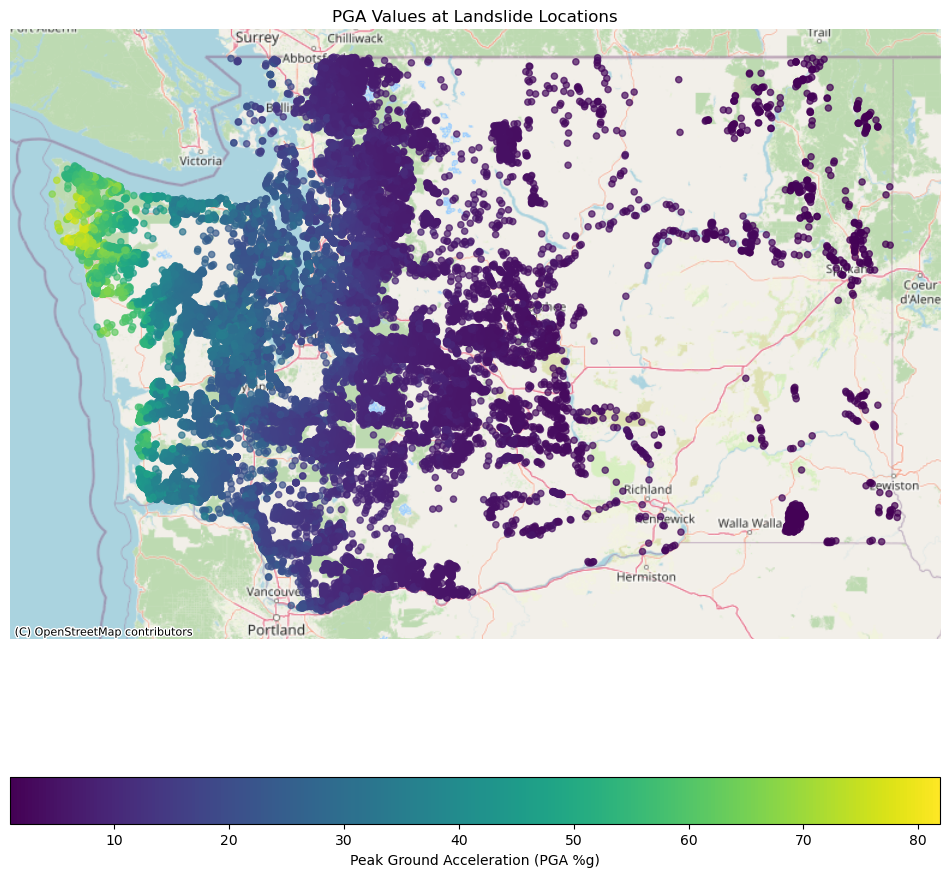

In [15]:
import contextily as cx

# Ensure the geometry is set to the 'centroid' column for plotting
landslides_gdf = landslides_gdf.set_geometry("centroid")
# Re-project the GeoDataFrame to Web Mercator (EPSG:3857) which is required by contextily
landslides_gdf_wm = landslides_gdf.to_crs(epsg=3857)    

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
# Plot the landslide data
landslides_gdf_wm.plot(column='filter_PGA',
                                ax=ax, 
                                legend=True, 
                                cmap='viridis', 
                                alpha=0.7,
                                markersize=20,
                                legend_kwds={'label': "Peak Ground Acceleration (PGA %g)",
                                            'orientation': "horizontal"})   

# Add the basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Set title and remove axis labels for a cleaner map look
ax.set_title('PGA Values at Landslide Locations')
ax.set_axis_off()
plt.show()

In [16]:
landslides_gdf.head()

,LANDSLIDE_ID,MATERIAL,MOVEMENT,MOVE_CODE,CONFIDENCE,RELATIVE_AGE,YEAR_MOVE,FIELD_VERIFIED,SLOPE_DEG,HS_HEIGHT_FT,...,filter_MATERIAL,filter_CONFIDENCE,geometry,centroid,lon,lat,filter_PGA,filter_MMI,filter_PGV,filter_PSA03
0,18414,Earth or debris,Flow,EFL,Low (1-10),Pre-historic (>150 years),None,No,11.0,3.0,...,Earth or debris,Low (1-10),"MULTIPOLYGON (((1043516.638 614643.978, 104351...",POINT (-122.89243 46.99396),-122.892431,46.993964,29.33,7.0,27.67,70.45
3,20661,Earth or debris,Topple,ET,Moderate (11-29),Pre-historic (>150 years),None,No,61.0,24.0,...,Earth or debris,Moderate (11-29),"MULTIPOLYGON (((1032543.812 660981.578, 103254...",POINT (-122.94205 47.12002),-122.942050,47.120019,24.45,7.3,34.02,64.60
5,20392,Earth or debris,Slide-Rotational,ES-R,Low (1-10),Pre-historic (>150 years),None,No,34.0,15.0,...,Earth or debris,Low (1-10),"MULTIPOLYGON (((1042187.543 664959.22, 1042188...",POINT (-122.9039 47.13174),-122.903901,47.131744,27.47,7.5,38.16,78.29
6,18573,Earth or debris,Flow,EFL,Low (1-10),Pre-historic (>150 years),None,No,29.0,6.0,...,Earth or debris,Low (1-10),"MULTIPOLYGON (((1011999.104 543485.112, 101200...",POINT (-123.00957 46.79624),-123.009570,46.796240,27.92,6.7,21.45,81.83
7,20357,Earth or debris,Flow,EFL,Low (1-10),Pre-historic (>150 years),None,No,20.0,9.0,...,Earth or debris,Low (1-10),"MULTIPOLYGON (((1021808.655 667705.559, 102181...",POINT (-122.98606 47.13753),-122.986060,47.137527,33.31,7.5,39.01,79.19


## Rainfall

30 years average annual rainfall data from: 30-Year (1990-2019) Annual Average of DAYMET Precipitation and Temperature for North America https://doi.org/10.5066/P9E0JZ82

In [17]:
import rasterio
from rasterio.transform import rowcol

rain_tif = "./rainfall-data/PPT9019.tif"

with rasterio.open(rain_tif) as src:
    # Transform lon/lat (EPSG:4326) -> raster CRS (NAD83 / Albers)
    tf = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
    xs, ys = tf.transform(landslides_gdf["lon"].values, landslides_gdf["lat"].values)

    # Identify which transformed points fall inside the raster bounds
    b = src.bounds
    in_bounds = (
        (xs >= b.left) & (xs <= b.right) &
        (ys >= b.bottom) & (ys <= b.top)
    )

    # Prepare output array, default to NaN
    vals = np.full(len(xs), np.nan, dtype="float64")

    # Sample only the points that are in-bounds
    coords_in = np.column_stack([xs[in_bounds], ys[in_bounds]])
    if len(coords_in) > 0:
        sampled = list(src.sample(coords_in))  # each is an array of band values
        sampled = np.array([s[0] for s in sampled], dtype="float64")

        # Replace raster NoData with NaN, if defined
        if src.nodata is not None:
            sampled[sampled == src.nodata] = np.nan

        vals[in_bounds] = sampled

# Add the column to your GeoDataFrame
landslides_gdf["filter_RAINFALL"] = vals
landslides_gdf.head()

,LANDSLIDE_ID,MATERIAL,MOVEMENT,MOVE_CODE,CONFIDENCE,RELATIVE_AGE,YEAR_MOVE,FIELD_VERIFIED,SLOPE_DEG,HS_HEIGHT_FT,...,filter_CONFIDENCE,geometry,centroid,lon,lat,filter_PGA,filter_MMI,filter_PGV,filter_PSA03,filter_RAINFALL
0,18414,Earth or debris,Flow,EFL,Low (1-10),Pre-historic (>150 years),None,No,11.0,3.0,...,Low (1-10),"MULTIPOLYGON (((1043516.638 614643.978, 104351...",POINT (-122.89243 46.99396),-122.892431,46.993964,29.33,7.0,27.67,70.45,1384.876221
3,20661,Earth or debris,Topple,ET,Moderate (11-29),Pre-historic (>150 years),None,No,61.0,24.0,...,Moderate (11-29),"MULTIPOLYGON (((1032543.812 660981.578, 103254...",POINT (-122.94205 47.12002),-122.942050,47.120019,24.45,7.3,34.02,64.60,1503.936035
5,20392,Earth or debris,Slide-Rotational,ES-R,Low (1-10),Pre-historic (>150 years),None,No,34.0,15.0,...,Low (1-10),"MULTIPOLYGON (((1042187.543 664959.22, 1042188...",POINT (-122.9039 47.13174),-122.903901,47.131744,27.47,7.5,38.16,78.29,1421.002563
6,18573,Earth or debris,Flow,EFL,Low (1-10),Pre-historic (>150 years),None,No,29.0,6.0,...,Low (1-10),"MULTIPOLYGON (((1011999.104 543485.112, 101200...",POINT (-123.00957 46.79624),-123.009570,46.796240,27.92,6.7,21.45,81.83,1401.459595
7,20357,Earth or debris,Flow,EFL,Low (1-10),Pre-historic (>150 years),None,No,20.0,9.0,...,Low (1-10),"MULTIPOLYGON (((1021808.655 667705.559, 102181...",POINT (-122.98606 47.13753),-122.986060,47.137527,33.31,7.5,39.01,79.19,1567.274048


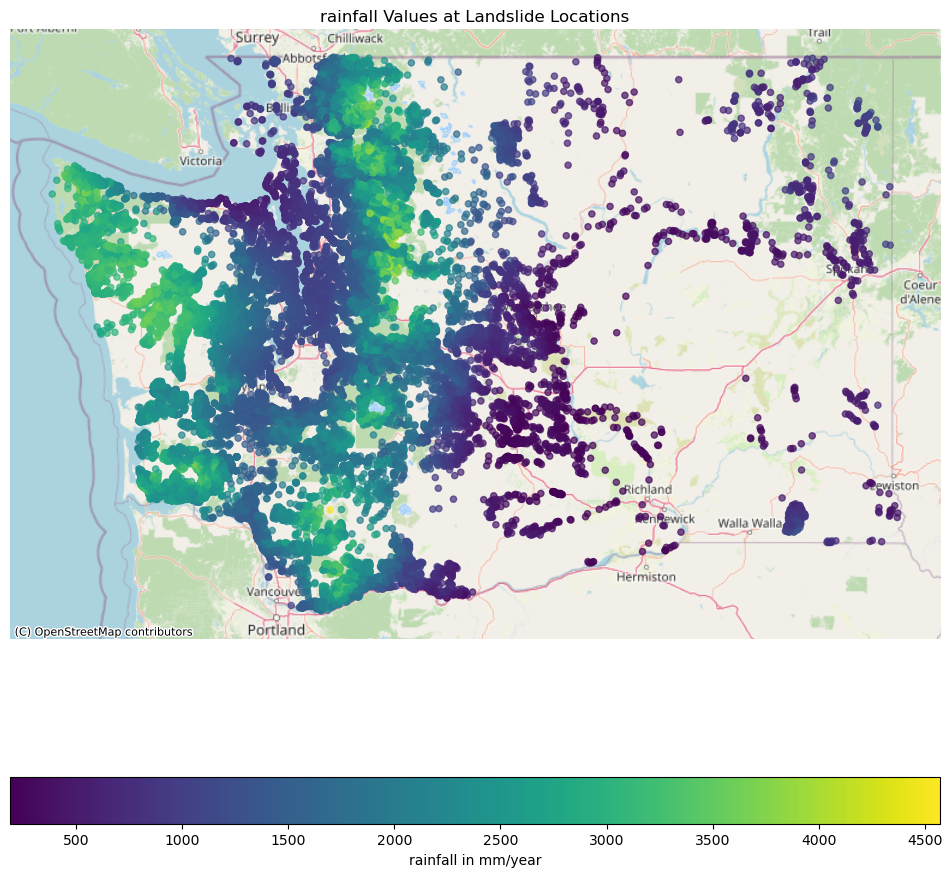

In [18]:
import contextily as cx

# Ensure the geometry is set to the 'centroid' column for plotting
landslides_gdf = landslides_gdf.set_geometry("centroid")
# Re-project the GeoDataFrame to Web Mercator (EPSG:3857) which is required by contextily
landslides_gdf_wm = landslides_gdf.to_crs(epsg=3857)    

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
# Plot the landslide data
landslides_gdf_wm.plot(column='filter_RAINFALL',
                                ax=ax, 
                                legend=True, 
                                cmap='viridis', 
                                alpha=0.7,
                                markersize=20,
                                legend_kwds={'label': "rainfall in mm/year",
                                            'orientation': "horizontal"})   

# Add the basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Set title and remove axis labels for a cleaner map look
ax.set_title('rainfall Values at Landslide Locations')
ax.set_axis_off()
plt.show()

## Add Unique ID 

Generate sequential unique identifiers for all landslide records

In [19]:
# Add a unique ID column to the landslides_gdf
landslides_gdf['viewer_id'] = [
    f"{origin}_{i+1}" for i, origin in enumerate(landslides_gdf['filter_ORIGIN'])
]

print(f"Added unique_id column with {len(landslides_gdf)} unique IDs")
print(landslides_gdf[['filter_ORIGIN', 'viewer_id']].head())

Added unique_id column with 60919 unique IDs
  filter_ORIGIN     viewer_id
0    WASHINGTON  WASHINGTON_1
3    WASHINGTON  WASHINGTON_2
5    WASHINGTON  WASHINGTON_3
6    WASHINGTON  WASHINGTON_4
7    WASHINGTON  WASHINGTON_5


## Save the Landslides

In [22]:
# Keep the original geometry column and remove centroid
gdf_export_original = landslides_gdf.copy()
gdf_export_original = gdf_export_original.set_geometry('geometry')  # Set original geometry as active
gdf_export_original = gdf_export_original.drop('centroid', axis=1)  # Remove the centroid geometry column

# Export with original geometry
gdf_export_original.to_file(f"final_{ds_name}_v2.geojson", driver="GeoJSON")
print(f"✓ Successfully saved with original geometry to: final_{ds_name}_v2.geojson")

✓ Successfully saved with original geometry to: final_washington_v2.geojson
